In [1]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

### 1. Veri Entegrasyonu ve Ön İşleme
Veri setleri yüklendikten sonra, kullanıcı yorumlarındaki duygu analizleri (`Sentiment`) sayısal hale getirilir ve ana uygulama veri seti ile birleştirilir. Bu adım, modelin tahmin gücünü artırmak için veriyi zenginleştirir.

In [3]:
apps_df = pd.read_csv("googleplaystore.csv")

reviews_df = pd.read_csv(
    "googleplaystore_user_reviews.csv",
    encoding="latin1",
    on_bad_lines="skip"
)

print("=== STEP 1: DATA LOADED ===")
print("Apps Shape   :", apps_df.shape)
print("Reviews Shape:", reviews_df.shape)
print("\nApps Columns:")
print(apps_df.columns.tolist())
print("\nReviews Columns:")
print(reviews_df.columns.tolist())



=== STEP 1: DATA LOADED ===
Apps Shape   : (10841, 13)
Reviews Shape: (64295, 5)

Apps Columns:
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']

Reviews Columns:
['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity', 'Sentiment_Subjectivity']


In [4]:
print("\n=== STEP 2: SENTIMENT PREPROCESSING ===")
print("Missing Sentiment_Polarity:",
      reviews_df['Sentiment_Polarity'].isna().sum())

reviews_df = reviews_df.dropna(subset=['Sentiment_Polarity'])
print("After dropna Reviews Shape:", reviews_df.shape)

sentiment_agg = reviews_df.groupby('App').agg({
    'Sentiment_Polarity': 'mean',
    'Sentiment_Subjectivity': 'mean'
}).reset_index()


sentiment_agg = sentiment_agg.rename(columns={
    'Sentiment_Polarity': 'Avg_Sentiment_Polarity',
    'Sentiment_Subjectivity': 'Avg_Sentiment_Subjectivity'
})

print("Sentiment Aggregated Columns:")
print(sentiment_agg.columns.tolist())
print("\nSentiment Preview:")
print(sentiment_agg.head().to_string(index=False))




=== STEP 2: SENTIMENT PREPROCESSING ===
Missing Sentiment_Polarity: 26863
After dropna Reviews Shape: (37432, 5)
Sentiment Aggregated Columns:
['App', 'Avg_Sentiment_Polarity', 'Avg_Sentiment_Subjectivity']

Sentiment Preview:
                                                                       App  Avg_Sentiment_Polarity  Avg_Sentiment_Subjectivity
                                                     10 Best Foods for You                0.470733                    0.495455
104 æ¾å·¥ä½ - æ¾å·¥ä½ æ¾æå·¥ æ¾å¼è· å±¥æ­·å¥æª¢ å±¥æ­·è¨ºçå®¤                0.392405                    0.545516
                                                                      11st                0.181294                    0.443957
                                                1800 Contacts - Lens Store                0.318145                    0.591098
                                         1LINE â One Line with One Touch                0.196290                    0.557315


In [5]:
df = apps_df.merge(sentiment_agg, on='App', how='left')

print("\n=== STEP 3: MERGE ===")
print("Merged Shape:", df.shape)
print("Merged Columns:")
print(df.columns.tolist())
print("\nMissing Sentiment After Merge:")
print(df[['Avg_Sentiment_Polarity',
          'Avg_Sentiment_Subjectivity']].isna().sum())



=== STEP 3: MERGE ===
Merged Shape: (10841, 15)
Merged Columns:
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver', 'Avg_Sentiment_Polarity', 'Avg_Sentiment_Subjectivity']

Missing Sentiment After Merge:
Avg_Sentiment_Polarity        9685
Avg_Sentiment_Subjectivity    9685
dtype: int64


In [6]:
print("sentiment_agg columns:")
print(sentiment_agg.columns.tolist())



sentiment_agg columns:
['App', 'Avg_Sentiment_Polarity', 'Avg_Sentiment_Subjectivity']


In [7]:
print("\n=== STEP 4: CLEANING ===")

df = df.copy()  # SettingWithCopyWarning

print("Missing Rating before:", df['Rating'].isna().sum())
df = df.loc[df['Rating'].notna()]
print("After drop Rating NA:", df.shape)

# Reviews
df.loc[:, 'Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Installs
df.loc[:, 'Installs'] = (
    df['Installs']
    .astype(str)
    .str.replace('[+,]', '', regex=True)
)
df.loc[:, 'Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Price
df.loc[:, 'Price'] = (
    df['Price']
    .astype(str)
    .str.replace('$', '', regex=True)
)
df.loc[:, 'Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Sentiment
df.loc[:, 'Avg_Sentiment_Polarity'] = pd.to_numeric(
    df['Avg_Sentiment_Polarity'], errors='coerce'
)
df.loc[:, 'Avg_Sentiment_Subjectivity'] = pd.to_numeric(
    df['Avg_Sentiment_Subjectivity'], errors='coerce'
)

print("\nMissing values before final drop:")
print(df.isna().sum())

df = df.dropna()

print("Final Shape after cleaning:", df.shape)



=== STEP 4: CLEANING ===
Missing Rating before: 1474
After drop Rating NA: (9367, 15)

Missing values before final drop:
App                              0
Category                         0
Rating                           0
Reviews                          1
Size                             0
Installs                         1
Type                             0
Price                          648
Content Rating                   1
Genres                           0
Last Updated                     0
Current Ver                      4
Android Ver                      3
Avg_Sentiment_Polarity        8212
Avg_Sentiment_Subjectivity    8212
dtype: int64
Final Shape after cleaning: (1140, 15)


### 2. Veri Temizleme ve Hedef Değişken
Veri setindeki gereksiz karakterler ($, + gibi) temizlenerek sayısal formata dönüştürülür.
* **Hedef Değişken (y):** `Rating` (Uygulama Puanı)
* **Özellikler (X):** `Reviews`, `Installs`, `Price` ve Sentiment skorları.

In [8]:
print("\n=== STEP 5: FEATURES & TARGET ===")

features = [
    'Reviews',
    'Installs',
    'Price',
    'Avg_Sentiment_Polarity',
    'Avg_Sentiment_Subjectivity'
]

X = df[features].values
y = df['Rating'].values

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nRating Statistics:")
print(pd.Series(y).describe())



=== STEP 5: FEATURES & TARGET ===
X shape: (1140, 5)
y shape: (1140,)

Rating Statistics:
count    1140.000000
mean        4.296140
std         0.304809
min         2.600000
25%         4.200000
50%         4.300000
75%         4.500000
max         4.900000
dtype: float64


### 3. Eğitim/Test Ayrımı ve Ölçeklendirme
Veri seti %80 Eğitim ve %20 Test olarak ayrılır. Yapay sinir ağlarının daha iyi çalışması için veriler `StandardScaler` ile standartlaştırılır.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling completed ✔")


Train size: (912, 5)
Test size : (228, 5)
Scaling completed ✔


### 4. Model 1: Yapay Sinir Ağı (Neural Network)
PyTorch kullanılarak katmanlı bir yapay sinir ağı oluşturulur.
* Veriler Tensor formatına çevrilir.
* Model, belirli sayıda `epoch` boyunca eğitilir ve `MSELoss` (Hata Kareler Ortalaması) minimize edilmeye çalışılır.

In [10]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

print("X_train_t:", X_train_t.shape)
print("y_train_t:", y_train_t.shape)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


X_train_t: torch.Size([912, 5])
y_train_t: torch.Size([912, 1])


In [11]:
class RatingNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = RatingNN(X_train.shape[1])
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



RatingNN(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [12]:
epochs = 50
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/50 - Loss: 489.6685
Epoch 2/50 - Loss: 384.4110
Epoch 3/50 - Loss: 247.3828
Epoch 4/50 - Loss: 118.9549
Epoch 5/50 - Loss: 59.8791
Epoch 6/50 - Loss: 43.8860
Epoch 7/50 - Loss: 35.5783
Epoch 8/50 - Loss: 30.2544
Epoch 9/50 - Loss: 25.8780
Epoch 10/50 - Loss: 22.2809
Epoch 11/50 - Loss: 19.2978
Epoch 12/50 - Loss: 16.7853
Epoch 13/50 - Loss: 14.0999
Epoch 14/50 - Loss: 12.2050
Epoch 15/50 - Loss: 10.0666
Epoch 16/50 - Loss: 8.5869
Epoch 17/50 - Loss: 7.2462
Epoch 18/50 - Loss: 6.1164
Epoch 19/50 - Loss: 5.2663
Epoch 20/50 - Loss: 4.5575
Epoch 21/50 - Loss: 4.0512
Epoch 22/50 - Loss: 3.6846
Epoch 23/50 - Loss: 3.3697
Epoch 24/50 - Loss: 3.1873
Epoch 25/50 - Loss: 3.0386
Epoch 26/50 - Loss: 2.8655
Epoch 27/50 - Loss: 2.7072
Epoch 28/50 - Loss: 2.6253
Epoch 29/50 - Loss: 2.5512
Epoch 30/50 - Loss: 2.4915
Epoch 31/50 - Loss: 2.4311
Epoch 32/50 - Loss: 2.3975
Epoch 33/50 - Loss: 2.3228
Epoch 34/50 - Loss: 2.2956
Epoch 35/50 - Loss: 2.2612
Epoch 36/50 - Loss: 2.2652
Epoch 37/50 - Loss

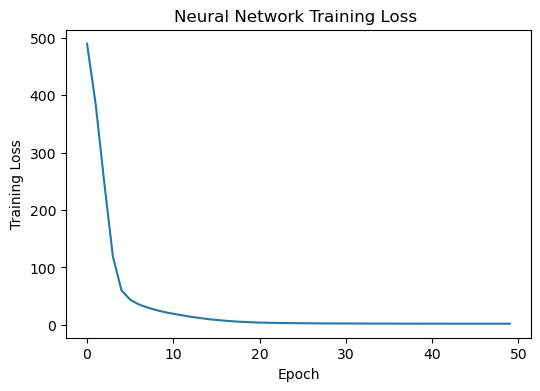

In [13]:

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Neural Network Training Loss ")
plt.show()


In [14]:
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_t).numpy().flatten()

print("\n=== Neural Network Results ===")
print("MAE :", mean_absolute_error(y_test, y_pred_nn))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_nn)))
print("R²  :", r2_score(y_test, y_pred_nn))



=== Neural Network Results ===
MAE : 0.19829511747025608
RMSE: 0.2654604080947618
R²  : 0.30331668070745377


### 5. Model 2: Gradient Boosting Regressor
Neural Network modeline alternatif olarak, yapılandırılmış verilerde (tabular data) genellikle çok yüksek performans gösteren ağaç tabanlı **Gradient Boosting Regressor** modeli eğitilir.
* **Avantajı:** Hızlı eğitilir ve verideki karmaşık ilişkileri yakalayabilir.
* Model eğitildikten sonra MAE, RMSE ve R² metrikleri hesaplanır.

In [15]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("\n=== Gradient Boosting Results ===")
print("MAE :", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("R²  :", r2_score(y_test, y_pred_gbr))



=== Gradient Boosting Results ===
MAE : 0.16829278970721506
RMSE: 0.24533438507208152
R²  : 0.4049509861692622


### 6. Tahminlerin Görselleştirilmesi (Actual vs Predicted)
Her iki modelin (Neural Network ve Gradient Boosting) test verisi üzerindeki tahmin başarısı bir saçılım grafiği üzerinde karşılaştırılır. Noktaların diyagonal çizgiye ne kadar yakın olduğu, modellerin başarısını gösterir.

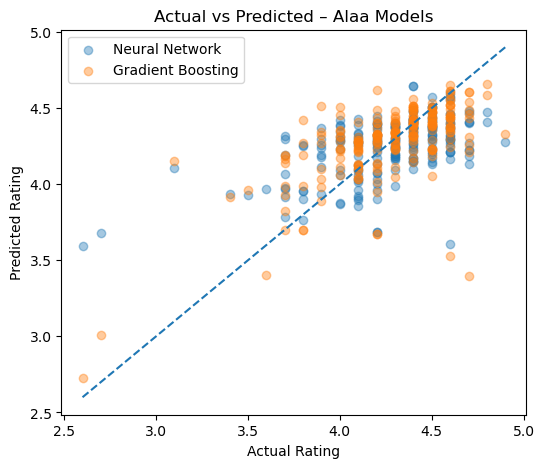

In [16]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_nn, alpha=0.4, label="Neural Network")
plt.scatter(y_test, y_pred_gbr, alpha=0.4, label="Gradient Boosting")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted – Alaa Models")
plt.legend()
plt.show()


### 7. Sonuçların Karşılaştırılması
Elde edilen sonuçlar bir tabloda özetlenir. Hangi modelin hata oranı (RMSE, MAE) daha düşükse ve R² skoru daha yüksekse, o modelin bu veri seti için daha uygun olduğuna karar verilir.

In [17]:
results_alaa = pd.DataFrame({
    "Model": ["Neural Network (PyTorch)", "Gradient Boosting Regressor"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_nn),
        mean_absolute_error(y_test, y_pred_gbr)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_nn)),
        np.sqrt(mean_squared_error(y_test, y_pred_gbr))
    ],
    "R²": [
        r2_score(y_test, y_pred_nn),
        r2_score(y_test, y_pred_gbr)
    ]
})

print("\nAlaa – Final Regression Comparison Table:")
print(results_alaa.to_string(index=False))



Alaa – Final Regression Comparison Table:
                      Model      MAE     RMSE       R²
   Neural Network (PyTorch) 0.198295 0.265460 0.303317
Gradient Boosting Regressor 0.168293 0.245334 0.404951
